# Bayesian Sample Visualizer (BSAVI)
This is the notebook where I'm currently developing the visualizer. I'm using Holoviews and Panel to construct the dashboard and implement the interactivity.

In [ ]:
import bsavi as bsv

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
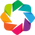

In [16]:
import holoviews as hv
from holoviews import dim, opts, streams
from holoviews.selection import link_selections
# import hvplot.pandas
import pandas as pd
from itertools import combinations
import numpy as np
from tqdm import trange, tqdm
import re
import panel as pn
import os
from bokeh.models import HoverTool
from classy import Class
import matplotlib.pyplot as plt
import copy
from multiprocessing import Pool
from typing import Callable

# pn.extension(loading_spinner='dots', loading_color='#00aa41', sizing_mode="stretch_width")

# hv.Store.set_current_backend('bokeh')
# pn.extension('tabulator')
hv.extension('bokeh')
pn.extension('tabulator')


## Function & Class Definitions

## Chain Loading

In [ ]:
# methods to process data products from the CLASS cosmology code.

# read in the .paramnames file and return a dict of parameters and their LaTeX formatting
def load_params(filename):
    params_list = []
    with open(filename, 'r') as f:
        for line in f:
            param_and_latex = line.split('\t')
            param_and_latex = [item.strip() for item in param_and_latex]
            params_list.append(param_and_latex)
    return dict(params_list)

# create a DataFrame from the chain files and use a list of parameters as the column names
def load_chains(path, params, params_only=True):
    if isinstance(path, list):
        array_list = [np.loadtxt(filename) for filename in tqdm(path)]
    else: 
        file_list = sorted(iglob(path))
        array_list = [np.loadtxt(filename) for filename in tqdm(file_list)]
    chains = np.vstack(array_list)
    columns = ['weight', '-LogLkl'] + params
    if params_only:
        df = pd.DataFrame(chains[:, 2:], columns=params)
    else:
        df = pd.DataFrame(chains, columns=columns)
    return df

In [10]:


# run class on the user's selection with default settings
def run_class(index, sample):
    selection = sample.iloc[[index]].to_dict('index')

    cosmo = Class()
    cosmo.set(selection[index])
    cosmo.set({'output':'mPk, tCl, pCl, lCl','P_k_max_1/Mpc':3.0, 'lensing':'yes'})
    cosmo.compute()

    # set variables for matter power spectrum and lensed CMB angular power spectra
    kk = np.logspace(-4,np.log10(3),1000)
    Pk = []
    h = cosmo.h()
    for k in kk:
        Pk.append(cosmo.pk(k*h,0.)*h**3)
    Pk = np.array(Pk)
    l = np.array(range(2,2501))
    factor = l*(l+1)/(2*np.pi)
    lensed_cl = cosmo.lensed_cl(2500)
    
    results = [
        {'k': kk, 'Pk': Pk},
        {'l': l, 'Cl_tt': factor*lensed_cl['tt'][2:]},
        {'l': l, 'Cl_ee': factor*lensed_cl['ee'][2:]}, 
    ]

    # results = {
    #     'k': kk, 
    #     'Pk': Pk, 
    #     'l': l, 
    #     'Cl_tt': factor*lensed_cl['tt'][2:], 
    #     'Cl_ee': factor*lensed_cl['ee'][2:], 
    # }
    # cleanups requried for backwards compat w CLASS 2.x
    cosmo.struct_cleanup()
    cosmo.empty()
    return results

# calculate percentage difference between model of interest and LambdaCDM model
def compute_residuals(index, sample, sample_CDM):
    if __name__ == '__main__':
        with Pool() as p:
            [mycosmo, LambdaCDM] = p.starmap(run_class, [(index, sample), (index, sample_CDM)])
    else:
        mycosmo = run_class(index, sample)
        LambdaCDM = run_class((index, sample_CDM))

    myPk, myCl_tt, myCl_ee = mycosmo
    LCDM_Pk, LCDM_Cl_tt, LCDM_Cl_ee = LambdaCDM
    pk_residuals = (myPk['Pk'] - LCDM_Pk['Pk'])/LCDM_Pk['Pk']*100
    cl_tt_residuals = (myCl_tt['Cl_tt'] - LCDM_Cl_tt['Cl_tt'])/LCDM_Cl_tt['Cl_tt']*100
    cl_ee_residuals = (myCl_ee['Cl_ee'] - LCDM_Cl_ee['Cl_ee'])/LCDM_Cl_ee['Cl_ee']*100
    
    residuals = [
        {'k': myPk['k'], 'pk_residuals': pk_residuals}, 
        {'l': myCl_tt['l'], 'cl_tt_residuals': cl_tt_residuals}, 
        {'l': myCl_ee['l'], 'cl_ee_residuals': cl_ee_residuals},
    ]
    return residuals

In [11]:
# unpacks the nested data
def unpacker(dataset, index):
    if isinstance(dataset, dict):
        unpacked_data = {key: dataset[key][index] for key in dataset.keys()}
    if isinstance(dataset, pd.core.frame.DataFrame):
        columns = dataset.columns
        dataseries = dataset.iloc[index]
        unpacked_data = pd.DataFrame({columns[item]: dataseries[columns[item]] for item in range(len(columns))})
    return unpacked_data

#  given a param name, find corresponding latex-formatted param name
def lookup_latex_label(param, latex_dict):
    # handle default case of no latex paramname dictionary
    if latex_dict is None:
        latex_dict = dict()
    try:
        latex_param = latex_dict[param]
        label = r'$${}$$'.format(latex_param)
        return label
    except KeyError:
        label = param
        return label
    
class Observable:
    """
    Observable class for BSAVI.
    
    Parameters
    ----------
    name: string or list of strings
        specifies the display name of the observable for things like plot titles
    parameters: dict-like or list of dict-likes
        the data to associated with that observable. can be python dict (or pandas DataFrame)
        whose keys (or column names) will be used for things like plot axis labels. 
    latex_labels: dict or list of dicts
        key: value -> parameter label: latex version. parameter label must match the
        corresponding one in the parameters dict
    myfunc: callable
        a user-provided function that returns parameters. can return more than one
        set of parameters if the "grouped" option is True
    myfunc_args: tuple
        arguments for user-provided function
    grouped: boolean
        specifies if user-provided function returns more than one set of parameters
    plot_type: string
        specifies how the data should be visualized. currently can pick either 'Curve'
        or 'Scatter'
    plot_opts: holoviews Options object
        customization options for the observable plot. see Holoviews documentation
    """
    
    def __init__(
        self, 
        name: str | list[str], 
        parameters: dict | list[dict] = None, 
        myfunc: Callable | list[Callable] = None, 
        myfunc_args: tuple = None, 
        plot_type: str | list[str] = None,
        plot_opts: type[opts] | list[type[opts]] = None,
        latex_labels: dict = None
    ):
        if isinstance(name, str):
            self.name = [name]
        else:
            self.name = name
        if isinstance(parameters, dict):
            self.parameters = [parameters]
        else:
            self.parameters = parameters
        self.myfunc = myfunc
        self.myfunc_args = myfunc_args
        if isinstance(plot_type, str):
            self.plot_type = [plot_type]
        else:
            self.plot_type = plot_type
        if isinstance(plot_opts, hv.core.options.Options):
            self.plot_opts = [plot_opts]
        else:
            self.plot_opts = plot_opts
        self.latex_labels = latex_labels
        self.number = len(self.name)
    
    def properties(self):
        if len(self.name) > 1:
            print("BSAVI Grouped Observables")
            for i in range(len(self.name)):
                print(f"\t- Observable {i+1}: {self.name[i]}")
        else:
            print("BSAVI Observable")
            print(f"Name: {self.name[0]}")
        
    def generate_plot(self, index: int):
        self.plots_list = []
        if self.myfunc and self.myfunc_args is not None:
            computed_data = self.myfunc(index, *self.myfunc_args)
            self.number = len(computed_data)
        for i in range(0, self.number):
            hv_element = getattr(hv, self.plot_type[i])
            if self.parameters is not None:
                dataset = self.parameters[i]
                unpacked_data = unpacker(dataset, index)
                kdim, vdim = unpacked_data.keys()
                plot = hv_element(unpacked_data, kdim, vdim, group=self.name[i], label=str(index))
            elif computed_data:
                dataset = computed_data[i]
                kdim, vdim = dataset.keys()
                plot = hv_element(dataset, kdim, vdim, group=self.name[i], label=str(index))
            # set defaults
            plot.opts(
                title=f'{self.name[i]}',
                tools=['hover'], 
                height=400,
                width=500,
                fontscale=1.1,
                padding=0.1,
                xlabel=lookup_latex_label(kdim, self.latex_labels), 
                ylabel=lookup_latex_label(vdim, self.latex_labels),
                framewise=True
            )
            # add user defined customizations
            if self.plot_opts and self.plot_opts[i] is not None:
                plot.opts(self.plot_opts[i])
            self.plots_list.append(plot)
        return self.plots_list
        
    def draw_plot(self, index):
        layout = hv.Layout(self.generate_plot(index))
        return layout.opts(shared_axes=False)
        
    

In [21]:
def viz(
    data, 
    observables: list = None, 
    show_observables: bool = True, 
    latex_dict: dict = None
):
    # setting Panel widgets for user interaction
    variables = data.columns.values.tolist()
    var1 = pn.widgets.Select(
        value=variables[0], 
        name='Horizontal Axis', 
        options=variables,
        width=150
    )
    var2 = pn.widgets.Select(
        value=variables[1], 
        name='Vertical Axis', 
        options=variables,
        width=150
    )
    hlog = pn.widgets.Checkbox(
        value=False, 
        name='Horiz. Log Scaling', 
        align='end',
        width=150
    )
    vlog = pn.widgets.Checkbox(
        value=False, 
        name='Vert. Log Scaling', 
        align='end',
        width=150
    )
    cmap_option = pn.widgets.Checkbox(
        value=True, 
        name='Show Colormap', 
        align='end',
        width=150
    )
    cmap_var = pn.widgets.Select(
        value=variables[1], 
        name='Colormap', 
        options=variables,
        width=150
    )
    cmap_option = pn.widgets.Checkbox(
        value=True, 
        name='Show Colormap', 
        align='end',
        width=150
    )


    # function for generating the scatter plot, given 2 dimensions as x and y axes, and an additional dimension to colormap
    # to the points on the plot. Also has an option to show or hide the colormap
    def plot_data(kdim1, xlog, kdim2, ylog, colordim, showcmap):
        if showcmap == True:
            cmapping = opts.Points(color=dim(colordim),
                colorbar=True,
                cmap='Spectral_r')
        else:
            cmapping = opts.Points(color='grey', colorbar=True)
        logscales = opts.Points(logx=xlog, logy=ylog)
        hover = HoverTool(tooltips=None)
        xlabel = lookup_latex_label(kdim1, latex_dict)
        ylabel = lookup_latex_label(kdim2, latex_dict)
        popts = opts.Points(
            bgcolor='#E5E9F0',
            fontscale=1.1,
            xlabel=xlabel,
            ylabel=ylabel,
            toolbar='above',
            line_color='black',
            clabel=colordim,
            #alpha=0.75, selection_alpha=1, nonselection_alpha=0.1,
            tools=[hover, 'box_select','lasso_select','tap'],
            size=7)
        points = hv.Points(data, kdims=[kdim1, kdim2]).opts(popts, cmapping, logscales)
        return points
    
    plot_data_copy = plot_data
    
    # bind the widget values to the plotting function so it gets called every time the user interacts with the widget
    # call the bound plotting function inside a holoview DynamicMap object for interaction
    interactive_points1 = pn.bind(plot_data, kdim1=var1, xlog=hax_log, kdim2=var2, ylog=vax_log, colordim=cmap_var, showcmap=cmap_option)
    interactive_points2 = pn.bind(plot_data_copy, kdim1=var1_copy, kdim2=var2_copy, colordim=cmap_var_copy, showcmap=cmap_option_copy)
    points_dmap1 = hv.DynamicMap(interactive_points1, kdims=[]).opts(width=500, height=400, framewise=True)
    points_dmap2 = hv.DynamicMap(interactive_points2, kdims=[]).opts(width=500, height=400, framewise=True)
    
    # define a stream to get a list of all the points the user has selected on the plot
    selection = streams.Selection1D(source=points_dmap1)
    
    # formatting the table using plot hooks
    def hook(plot, element):
        plot.handles['table'].autosize_mode = "none"
        for column in plot.handles['table'].columns:
            column.width = 100
    
    # function to generate a table of all the selected points
    def make_table(kdim1, kdim2, colordim):
        table_options = opts.Table(height=400, width=600, hooks=[hook], bgcolor='#f5f5f5')
        data_with_index = data.reset_index()
        table = hv.DynamicMap(lambda index: hv.Table(data_with_index.iloc[index], kdims=['index', kdim1, kdim2, colordim]), streams=[selection])
        return table.opts(table_options).relabel('Selected Points')
    
    
    # generate the table
    selected_table = pn.bind(make_table, kdim1=var1, kdim2=var2, colordim=cmap_var)
    
    #table_stream = streams.Selection1D(source=selected_table)
    
    # handles the null selection case and multiple selections
    plots = {}
    # get total number of plots to draw from list of observables
    plotting_info = {}
    if observables is None:
        observables = []
    for each in observables:
        for i in range(len(each.name)):
            if each.plot_opts is None:
                specific_opts = None
            elif each.plot_opts[i] is not None:
                specific_opts = each.plot_opts[i]
            plotting_info[each.name[i]] = {'type': each.plot_type[i], 'opts': specific_opts}
    def plot_observables(index):
        if not index:
            plots_list = []
            for name in plotting_info:
                hv_type = getattr(hv, plotting_info[name]['type'])
                empty_plot = hv_type(np.random.rand(0, 2), group=f'{name}', label='None').opts(
                    title=f'{name} - No Selection', 
                    height=400, 
                    width=500, 
                    fontscale=1.1, 
                    framewise=True)
                if plotting_info[name]['opts'] is not None:
                    empty_plot.opts(plotting_info[name]['opts'])
                plots_list.append([empty_plot])
        else:
            new_index = [x for x in index if x not in list(plots.keys())]
            for element in new_index:
                new_plots = []
                for each in observables:
                    new_plots.extend(each.generate_plot(element))
                plots[element] = {plot.group: plot for plot in new_plots}
            
            plots_list = []
            for index_item in index:
                plot_types = list(plots[index_item].keys())

            for plot_item in plot_types:
                same_type = [plots[key][plot_item] for key in index]
                plots_list.append(same_type)
            
        layout = hv.Layout()
        for list_of_plots in plots_list:
            overlay = hv.Overlay(list_of_plots).opts(show_legend=True, legend_position='right')
            layout = layout + overlay
        layout.opts(shared_axes=False).cols(2)
        return layout
    
    
    # put it all together using Panel
    input_panel1 = pn.Row(pn.Column(var1, hax_log, var2, vax_log, cmap_var, cmap_option), points_dmap1)
    input_panel2 = pn.Row(pn.Column(var1_copy, var2_copy, cmap_var_copy, cmap_option_copy), points_dmap2)
    dashboard = pn.Column(input_panel1, selected_table)
    
    if show_observables == True:
        observables_dmap = hv.DynamicMap(plot_observables, streams=[selection]).opts(framewise=True)
        observables_pane = pn.panel(observables_dmap)
        dashboard = pn.Row(dashboard, observables_pane)
    
    return dashboard

In [24]:
checkbox = pn.widgets.Checkbox(name='Logscale', value=True)
scatter = lambda y: hv.Scatter([1, 2, 3, 4, 5, 6, 7]).opts(title=str(y), logy=y)
plot = pn.bind(scatter, checkbox)
dmap = hv.DynamicMap(plot)
pn.Column(checkbox, plot, dmap).servable()

Column
    [0] Checkbox(name='Logscale', value=True)
    [1] ParamFunction(function, _pane=HoloViews)
    [2] HoloViews(DynamicMap, height=300, sizing_mode='fixed', width=300)

## Visualizing
Now we just need to load in our data, convert it into a format that CLASS accepts, and call `viz` to produce the dashboard.

In [5]:
# Read in data
loglkl = ['loglkl']
param_names, latex_params = load_params('../data/chains_planckbossdes_1MeV/2022-11-16_3200000_.paramnames')
params_latex_form = dict(zip(param_names, latex_params))
column_names = loglkl + param_names
df = pd.DataFrame(columns=column_names)
for i in trange(1,5):
    temp = load_data('../data/chains_planckbossdes_1MeV/2022-11-16_3200000__{}.txt'.format(i), column_names=column_names)
    df = pd.concat([df,temp]).reset_index(drop=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


In [6]:
df

,loglkl,omega_b,omega_cdm,100theta_s,ln10^{10}A_s,n_s,tau_reio,sigma_dmeff,A_cib_217,xi_sz_cib,...,b^{(3)}_{G_2},b^{(4)}_1,b^{(4)}_2,b^{(4)}_{G_2},z_reio,Omega_Lambda,YHe,H0,A_s,sigma8
0,2175.92,2.233439,0.120764,1.041234,3.050095,0.965456,0.046919,0.363654,47.20000,0.420000,...,-0.091663,1.879700,-3.211500,0.751040,6.935165,0.678496,0.247825,66.87360,2.111735,0.814656
1,2130.55,2.218251,0.122817,1.041719,3.036664,0.962108,0.055080,1.218752,47.20000,0.420000,...,-0.091663,1.879700,-3.211500,0.751040,7.858170,0.667484,0.247759,66.19007,2.083563,0.813204
2,2121.29,2.218251,0.122817,1.041719,3.036664,0.962108,0.055080,1.218752,49.25899,0.621416,...,-0.091663,1.879700,-3.211500,0.751040,7.858170,0.667484,0.247759,66.19007,2.083563,0.813204
3,2117.77,2.218251,0.122817,1.041719,3.036664,0.962108,0.055080,1.218752,49.79547,0.681129,...,-0.091663,1.879700,-3.211500,0.751040,7.858170,0.667484,0.247759,66.19007,2.083563,0.813204
4,2109.60,2.218251,0.122817,1.041719,3.036664,0.962108,0.055080,1.218752,48.40013,0.659446,...,-0.091663,1.879700,-3.211500,0.751040,7.858170,0.667484,0.247759,66.19007,2.083563,0.813204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568095,1937.34,2.253373,0.121202,1.042665,3.027404,0.969667,0.041868,14.132730,42.91239,0.630840,...,-0.574814,1.968162,0.514102,0.089302,6.353989,0.681881,0.247909,67.37722,2.064356,0.773952
568096,1936.85,2.253373,0.121202,1.042665,3.027404,0.969667,0.041868,14.132730,44.98069,0.693282,...,-0.573564,1.964785,0.531943,0.060431,6.353989,0.681881,0.247909,67.37722,2.064356,0.773952
568097,1937.42,2.253373,0.121202,1.042665,3.027404,0.969667,0.041868,14.132730,44.98069,0.693282,...,-0.717249,1.953972,0.621218,-0.045761,6.353989,0.681881,0.247909,67.37722,2.064356,0.773952
568098,1939.63,2.253373,0.121202,1.042665,3.027404,0.969667,0.041868,14.132730,44.98069,0.693282,...,-0.814384,1.948705,0.747522,-0.207377,6.353989,0.681881,0.247909,67.37722,2.064356,0.773952


In [7]:
classy_input = df.loc[:, ('omega_b', 'omega_cdm', 'ln10^{10}A_s', 'n_s', 'tau_reio', 'sigma_dmeff', 'Omega_Lambda', 'YHe', 'H0')]
classy_input['omega_b'] = classy_input['omega_b'] * 1e-2
classy_input['sigma_dmeff'] = classy_input['sigma_dmeff'] * 1e-25
classy_input = classy_input.rename(columns={'H0':'h'})
classy_input['h'] = classy_input['h'] * 1e-2
classy_input['f_dmeff'] = 0.1
classy_input['npow_dmeff'] = 0.0
classy_input['Vrel_dmeff'] = 0.0
classy_input['dmeff_target'] = 'baryons'
classy_input['m_dmeff'] = 1e-3

# format for CDM version
#classy_CDM = classy_input.drop(columns=['sigma_dmeff', 'omega_cdm', 'npow_dmeff', 'Vrel_dmeff', 'dmeff_target', 'm_dmeff'])
# classy_CDM = classy_CDM.rename(columns={'omega_dmeff':'omega_cdm'})
classy_CDM = classy_input.drop(columns=['sigma_dmeff', 'npow_dmeff', 'Vrel_dmeff', 'dmeff_target', 'm_dmeff'])


# slice for fast computation
classy_input_slice = classy_input[::500].reset_index(drop=True)
classy_CDM_slice = classy_CDM[::500].reset_index(drop=True)
df_slice = df[::500].reset_index(drop=True)

In [7]:
interp_df = pd.read_pickle('../data/trey_uvlf/bouwens_2023_data.pkl')
binned_df = pd.read_pickle('../data/trey_uvlf/bouwens_2023_data_binned.pkl')

In [8]:
binned_slice = binned_df[::25].reset_index(drop=True)
params_df = binned_slice[['alphaOutflow', 'alphaStar', 'like', 'timescale', 'velocityOutflow']]
lumfunc_df = binned_slice[['uvlf_Muv', 'uvlf_z10.5', 'uvlf_z12.6', 'uvlf_z8.7']]
lumfunc_latex = {
    'alphaOutflow': r'\alpha_{\mathrm{Outflow}}',
    'alphaStar': r'\alpha_{Star}',
    'timescale': r'\text{timescale}',
    'velocityOutflow': r'v_{\mathrm{Outflow}}',
    'like': r'\text{likelihood}'
}

### The Viz Function

The viz function has three arguments:
- __data__: (Pandas DataFrame) the data you want shown as a scatter plot
- __myfunction__: (function) your function that computes some observables based on a data point
- __function_args__: (tuple) the arguments of that function
- __show_observables__: (Boolean) whether you want to see the observable plots or not 

Be aware that if you pass data with categorical values (i.e. strings) in the first argument, the visualizer will break. It's fine to do so for the CLASS arguments though.

In [10]:
cosmo_copts = opts.Curve(width=500, height=400, logx=True, color=hv.Cycle('Spectral'), bgcolor='#22262F', framewise=True)
cosmo_latex = {
    'k': 'k~[h/\mathrm{Mpc}]',
    'pk_residuals': '(P(k)-P_{CDM}(k))/P_{CDM}(k)*100~[\%]',
    'l': '\ell',
    'cl_tt_residuals': '(C_{\ell}^{TT}-C_{\ell, CDM}^{TT})/C_{\ell, CDM}^{TT}*100~[\%]',
    'cl_ee_residuals': '(C_{\ell}^{EE}-C_{\ell, CDM}^{EE})/C_{\ell, CDM}^{EE}*100~[\%]',
}
cosmo_observables = Observable(
    name=[
        'P(k) Residuals', 
        'Cl_TT Residuals', 
        'Cl_EE Residuals', 
    ], 
    myfunc=compute_residuals,
    myfunc_args=(classy_input_slice, classy_CDM_slice), 
    plot_type=[
        'Curve', 
        'Curve', 
        'Curve', 
    ],
    plot_opts=[
        cosmo_copts, 
        cosmo_copts, 
        cosmo_copts, 
    ],
    latex_labels=cosmo_latex
)

In [11]:
cosmo_observables.generate_plot(0)[0]

:Curve   [k]   (pk_residuals)

In [12]:
viz(data=df_slice, observables=[cosmo_observables], latex_dict=params_latex_form).servable()

Row
    [0] Column
        [0] Row
            [0] Column
                [0] Select(name='Horizontal Axis', options=['loglkl', 'omega_b', ...], value='loglkl', width=150)
                [1] Checkbox(align='end', name='Horiz. Log Scaling', width=150)
                [2] Select(name='Vertical Axis', options=['loglkl', 'omega_b', ...], value='omega_b', width=150)
                [3] Checkbox(align='end', name='Vert. Log Scaling', width=150)
                [4] Select(name='Colormap', options=['loglkl', 'omega_b', ...], value='omega_cdm', width=150)
                [5] Checkbox(align='end', name='Show Colormap', value=True, width=150)
            [1] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=500)
        [1] ParamFunction(function, _pane=HoloViews)
    [1] HoloViews(DynamicMap)

In [22]:
uvlf_scatter_opts = opts.Scatter(ylim=(1e-11, 1e0), logy=True, invert_xaxis=True, size=3, marker='square')
uvlf_curve_opts = opts.Curve(ylim=(1e-11, None), logy=True, invert_xaxis=True)
uvlf_latex = {
    'uvlf_Muv': r'\text{UV Magnitude}',
    'uvlf_z10.5': r'\text{Luminosity Function}',
    'uvlf_z12.6': r'\text{Luminosity Function}',
    'uvlf_z8.7': r'\text{Luminosity Function}',
}
uvlf_observables = Observable(
    name=[
        'UVLF at z = 10.5', 
        'UVLF at z = 12.6', 
        'UVLF at z = 8.7'
    ], 
    parameters=[
        # {'uvlf_Muv': lumfunc_df['uvlf_Muv'], 'uvlf_z10.5': lumfunc_df['uvlf_z10.5']}, 
        # {'uvlf_Muv': lumfunc_df['uvlf_Muv'], 'uvlf_z12.6': lumfunc_df['uvlf_z12.6']}, 
        # {'uvlf_Muv': lumfunc_df['uvlf_Muv'], 'uvlf_z8.7': lumfunc_df['uvlf_z8.7']}, 
        lumfunc_df[['uvlf_Muv', 'uvlf_z10.5']], 
        lumfunc_df[['uvlf_Muv', 'uvlf_z12.6']], 
        lumfunc_df[['uvlf_Muv', 'uvlf_z8.7']], 
    ], 
    plot_type=[
        'Curve', 
        'Curve', 
        'Curve', 
    ],
    plot_opts=[
        uvlf_curve_opts, 
        uvlf_curve_opts, 
        uvlf_curve_opts, 
    ],
    latex_labels=uvlf_latex
)

In [23]:
viz(data=params_df, observables=[uvlf_observables], latex_dict=lumfunc_latex)

Row
    [0] Column
        [0] Row
            [0] Column
                [0] Select(name='Horizontal Axis', options=['alphaOutflow', ...], value='alphaOutflow', width=150)
                [1] Checkbox(align='end', name='Horiz. Log Scaling', width=150)
                [2] Select(name='Vertical Axis', options=['alphaOutflow', ...], value='alphaStar', width=150)
                [3] Checkbox(align='end', name='Vert. Log Scaling', width=150)
                [4] Select(name='Colormap', options=['alphaOutflow', ...], value='alphaStar', width=150)
                [5] Checkbox(align='end', name='Show Colormap', value=True, width=150)
            [1] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=500)
        [1] ParamFunction(function, _pane=HoloViews)
    [1] HoloViews(DynamicMap)

## WIP
The below cells are being used to further develop the visualizer.

In [9]:
lfdf = lumfunc_df[['uvlf_Muv', 'uvlf_z10.5']]
unpacker(lfdf, 0)

,uvlf_Muv,uvlf_z10.5
0,-24.5,0.000000e+00
1,-23.5,0.000000e+00
2,-22.5,0.000000e+00
3,-21.5,2.533742e-07
4,-20.5,4.742200e-07
5,-19.5,5.021252e-06
6,-18.5,1.722452e-05
7,-17.5,6.945006e-05
8,-16.5,2.231994e-04
9,-15.5,9.882875e-04


In [13]:
lfdf

,uvlf_Muv,uvlf_z10.5
0,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 4.7422..."
1,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 6.3179..."
2,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 6.4213..."
3,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 5.5842..."
4,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 7.5824..."
5,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 4.7422..."
6,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 6.4213..."
7,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 6.6020..."
8,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 6.4213..."
9,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 4.6772..."


In [52]:
hv.Table(df[:5]).opts(width=1000, fit_columns=True)

:Table   [loglkl,omega_b,omega_cdm,100theta_s,ln10^{10}A_s,n_s,tau_reio,sigma_dmeff,A_cib_217,xi_sz_cib,A_sz,ps_A_100_100,ps_A_143_143,ps_A_143_217,ps_A_217_217,ksz_norm,gal545_A_100,gal545_A_143,gal545_A_143_217,gal545_A_217,galf_TE_A_100,galf_TE_A_100_143,galf_TE_A_100_217,galf_TE_A_143,galf_TE_A_143_217,galf_TE_A_217,calib_100T,calib_217T,A_planck,b^{(1)}_1,b^{(1)}_2,b^{(1)}_{G_2},b^{(2)}_1,b^{(2)}_2,b^{(2)}_{G_2},b^{(3)}_1,b^{(3)}_2,b^{(3)}_{G_2},b^{(4)}_1,b^{(4)}_2,b^{(4)}_{G_2},z_reio,Omega_Lambda,YHe,H0,A_s,sigma8]

In [16]:
test_params = {'omega_b': 2.268118e-2, 
               'omega_dmeff': 0.1221163, 
               'ln10^{10}A_s': 3.048006, 
               'n_s': 0.9670508, 
               'tau_reio': 0.05659527, 
               'sigma_dmeff': 1.193e-25, 
               'Omega_Lambda': 0.6772064, 
               'YHe': 0.2479716, 
               'h': 67.13298e-2,  
               'omega_cdm': 1e-15, 
               'npow_dmeff': 0, 
               'Vrel_dmeff': 0, 
               'dmeff_target': 'baryons', 
               'm_dmeff': 0.001}
test_params_CDM = {'omega_b': 2.268118e-2, 
                   'omega_cdm': 0.1221163, 
                   'ln10^{10}A_s': 3.048006, 
                   'n_s': 0.9670508, 
                   'tau_reio': 0.05659527, 
                   'Omega_Lambda': 0.6772064, 
                   'YHe': 0.2479716, 
                   'h': 67.13298e-2}

In [42]:
%%time
run = run_class(1, classy_input_slice)
cdm_run = run_class(1, classy_CDM_slice)

CPU times: user 6.72 s, sys: 51.2 ms, total: 6.77 s
Wall time: 6.74 s


In [43]:
(hv.Curve(run[0], 'k', 'Pk') + hv.Curve(cdm_run[0], 'k', 'Pk')).opts(opts.Curve(logx=True))

:Layout
   .Curve.I  :Curve   [k]   (Pk)
   .Curve.II :Curve   [k]   (Pk)

In [ ]:
args = (classy_input_slice, classy_CDM_slice)
resids19 = compute_residuals(19, *args)
resids20 = compute_residuals(20, *args)
resids21 = compute_residuals(21, *args)

resids = {19: resids19, 20: resids20, 21: resids21}

In [ ]:
resids_df = pd.DataFrame.from_dict(resids, orient='index')
resids_df

In [ ]:
reshaped_uvlf

In [ ]:
data = df_slice
popts = opts.Points(
    toolbar='above',
    line_color='black',
    #alpha=0.5, selection_alpha=1, nonselection_alpha=0.1,
    tools=['box_select','lasso_select','tap'],
    size=7)
numerical_points = hv.Points(data, kdims=['omega_b', 'omega_cdm']).opts(popts)
selection = streams.Selection1D(source=numerical_points)

selections = []
def record_selections(index):
    new_index = [x for x in index if x not in list(set(selections))]
    prev_index = [x for x in index if x not in new_index]
    new = hv.Points(df_slice.iloc[new_index], kdims=['omega_b', 'omega_cdm']).relabel('new')
    old = hv.Points(df_slice.iloc[prev_index], kdims=['omega_b', 'omega_cdm']).relabel('old')
    if None not in index:
        selections.extend(index)
    return new * old

def show_prev_selections(index):
    if not index:
        return hv.Points(df_slice.iloc[index], kdims=['omega_b', 'omega_cdm']).relabel('no selection')

    new_index = [x for x in index if x not in list(set(selections))]
    prev_index = [x for x in index if x not in new_index]
    # old_index = prev_index + [x for x in list(set(selections)) if x not in prev_index]
    return hv.Points(df_slice.iloc[prev_index], kdims=['omega_b', 'omega_cdm']).relabel('previous')

def show_selection_record(index):  
    new_index = [x for x in index if x not in list(set(selections))]
    prev_index = [x for x in index if x not in new_index]
    old_index = prev_index + [x for x in list(set(selections)) if x not in prev_index]
    return hv.Points(df_slice.iloc[old_index], kdims=['omega_b', 'omega_cdm']).relabel('old')


responsive_dmap = hv.DynamicMap(record_selections, streams=[selection]).opts(popts)
prev_dmap = hv.DynamicMap(show_prev_selections, streams=[selection]).opts(popts)
old_dmap = hv.DynamicMap(show_selection_record, streams=[selection]).opts(popts)

numerical_points + responsive_dmap + old_dmap

In [ ]:
index = selection.contents['index']
new_index = [x for x in index if x in list(set(selections))]
prev_index = [x for x in index if x not in new_index]
old_index = prev_index + [x for x in list(set(selections)) if x not in prev_index]
print(f'new index: \n{new_index} \nprevious index: \n{prev_index} \nold index: \n{old_index}')

In [ ]:
from holoviews.operation import decimate
decimate.max_samples=2000
points = hv.Points(df, kdims=['omega_b', 'omega_cdm']).opts(width=500, height=400)
decimate(points)

In [ ]:
decimate(points) + hv.Points(df_slice, kdims=['omega_b', 'omega_cdm']).opts(width=500, height=400)

In [ ]:
def format_list(l):
    print(' '.join(sorted([k for k in l if not k.endswith('_r')])))
format_list(hv.Cycle.default_cycles.keys())
format_list(hv.Palette.colormaps.keys())

In [ ]:
def plot_scatter_table(data, params, plots):
    # kwargs:
    # data: a pandas DataFrame
    # params: list of parameters that correspond to column names in the DataFrame
    # plots: the number of plots to display
    
    # generate a list of all pairs of the parameters
    pairs = [list(comb) for comb in combinations(params, 2)]
    
    # create linked selections
    ls = link_selections.instance()
    
    layout = hv.Layout()
    
    for param_a, param_b in pairs[:plots]:
        # vdims = [e for e in params if e not in (param_a, param_b)]
        # ^^^ uncomment the above and add ", vdims" to the argument of hv.Dataset if desired
        ds = hv.Dataset(data, [param_a, param_b])
        pts = hv.Points(ds).opts(
            opts.Points(color='black', size=2))
        bivar = hv.Bivariate(data[[param_a,param_b]].values, [param_a,param_b], []).opts(
            opts.Bivariate(bandwidth=0.5,
                           cut=0,cmap="blues",
                           levels=5,
                           colorbar=False,
                           show_legend=False,
                           filled=True,
                           toolbar='above',
                           width=350,
                           alpha=0.75))
        layout += (ls(pts)*bivar).opts(width=300, height=300)
    
    layout = layout.cols(4)
    
    table = pn.widgets.Tabulator(data[params], disabled=True)
    selection = pn.widgets.Tabulator(disabled=True)
    try:
        table.selection = ls.selection_expr
    except ValueError:
        table.selection = []
    
    button_show_selection = pn.widgets.Button(name='Show selected rows only', button_type='primary', width_policy='auto')
    button_download_selection = pn.widgets.Button(name='Download selections as CSV', button_type='primary', width_policy='auto')
    button_reset = pn.widgets.Button(name='Reset', width_policy='auto')
    
    def show_selection(event):
        selection.value = table.selected_dataframe.sort_index()
    
    def download_selection(event):
        os.makedirs('data/selections', exist_ok=True)
        selection_df_sorted = table.selected_dataframe.sort_index()
        selection_df_sorted.to_csv('data/selections/selected_output.csv', index=False)

    def reset(event):
        table.selection = []
        selection.value = table.selected_dataframe

    button_show_selection.on_click(show_selection)
    button_download_selection.on_click(download_selection)
    button_reset.on_click(reset)
    dashboard = pn.Row(table, pn.Column(pn.Row(button_show_selection, button_download_selection, button_reset), selection))
    params = pn.Param(ls, parameters=['selection_mode'])
    scatter_table = pn.Column(params, pn.Row(layout), dashboard)
    return scatter_table

In [ ]:
params = ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'sigma_dmeff', 'H0', 'A_s', 'sigma8']
viz = plot_scatter_table(df_slice, params, plots=4)
viz

In [ ]:
menu_items = list(ds.data)
menu_button = pn.widgets.MenuButton(name='Parameter', items=menu_items, button_type='primary')
text = pn.widgets.TextInput(value='Ready')

def b(event):
    text.value = f'Clicked menu item: "{event.new}"'
    
menu_button.on_click(b)

pn.Row(menu_button, text, height=300)

In [ ]:
ds = hv.Dataset(new_df, ['omega_b', 'sigma_dmeff'])
vdims = ['omega_b', 'omega_dmeff', 'ln10^{10}A_s', 'n_s', 'tau_reio', 'sigma_dmeff', 'Omega_Lambda', 'H0']
layout = hv.Layout()
for vdim in vdims:
    if vdim != ds.kdims[0].name and vdim != ds.kdims[1].name:
        pts = hv.Points(ds).opts(color=dim(vdim),
            colorbar=True,
            cmap='Magma',
            alpha=0.5, selection_alpha=1, nonselection_alpha=0.1,
            tools=['box_select','lasso_select','tap'],
            size=5,
            width=350,
            height=250).relabel(vdim)
        layout += pts

layout.opts(shared_axes=False).cols(3)

In [ ]:
def plot_data(kdim1, kdim2, colordim, showcmap):  
    popts = opts.Points(
        toolbar='above',
        line_color='black',
        #alpha=0.5, selection_alpha=1, nonselection_alpha=0.1,
        tools=['box_select','lasso_select','tap'],
        size=7)
    
    if classy_input_slice[colordim].dtype == object:
        if showcmap == False:
            cmapping = opts.Points(color='grey')
        cmapping = opts.Points(color=dim(colordim), cmap='Category20')
        categorical_points = hv.Points(classy_input_slice, kdims=[kdim1, kdim2]).opts(popts, cmapping)
        return categorical_points
    else:
        if showcmap == False:
            cmapping = opts.Points(color='grey')
        cmapping = opts.Points(color=dim(colordim), cmap='Viridis', colorbar=True)
        numerical_points = hv.Points(classy_input_slice, kdims=[kdim1, kdim2]).opts(popts, cmapping)
        return numerical_points
        

def plot_dist(kdim1):
    dist = hv.Distribution(new_df, kdim1).opts(
        alpha=1,
        color='blue')
    return dist

def plot_bivar(kdim1, kdim2):
    bivar = hv.Bivariate(classy_input_slice, kdims=[kdim1, kdim2]).opts(
        cmap='blues',
        bandwidth=1,
        cut=0,
        levels=5,
        filled=True)
    return bivar

def choose_dist(kdim1, kdim2):
    if kdim1 == kdim2:
        return hv.DynamicMap(plot_dist, kdim1=kdim1).opts(width=500, height=400, framewise=True)
    else:
        return hv.DynamicMap(plot_bivar, kdim1=kdim1, kdim2=kdim2).opts(width=500, height=400, framewise=True)

In [ ]:
variables = classy_input_slice.columns.values.tolist()
var1 = pn.widgets.Select(value=variables[0], name='Horizontal Axis', options=variables)
var2 = pn.widgets.Select(value=variables[1], name='Vertical Axis', options=variables)
cmap_var = pn.widgets.Select(value='omega_b', name='Colormapped Parameter', options=variables)
cmap_option = pn.widgets.Checkbox(value=False, name='Show Colormap', align='end')

In [ ]:
interactive_points = pn.bind(plot_data, kdim1=var1, kdim2=var2, colordim=cmap_var, showcmap=cmap_option)
interactive_dist = pn.bind(choose_dist, kdim1=var1, kdim2=var2)
dmap_points = hv.DynamicMap(interactive_points).opts(width=500, height=400, framewise=True)
#dmap_dist = hv.DynamicMap(interactive_dist).opts(width=500, height=400, framewise=True)
app = pn.Column(pn.Row(var1, var2, cmap_var, cmap_option, width = 700), dmap_points)
app

In [ ]:
choose_dist('omega_b','omega_cdm')

In [ ]:
table = hv.Table(new_df, kdims=['omega_b', 'omega_dmeff', 'sigma_dmeff'])
table_sel = streams.Selection1D(source=table)

In [ ]:
table_sel.contents

In [ ]:
# Set up the parameters of the problem.
ndim, nsamples = 3, 1000

# Generate some fake data.
np.random.seed(42)
data1 = np.random.randn(ndim * 4 * nsamples // 5).reshape(
    [4 * nsamples // 5, ndim]
)
data2 = 4 * np.random.rand(ndim)[None, :] + np.random.randn(
    ndim * nsamples // 5
).reshape([nsamples // 5, ndim])
data = np.vstack([data1, data2])

In [ ]:
param_names = ['frequency', 'phase', 'amplitude']
latex = ['\omega / 2\pi', '\phi', '\mathrm{amplitude}']
wavedf = pd.DataFrame(data, columns=param_names)
latex_dict = dict(zip(param_names, latex))

In [ ]:
from scipy import signal

def compute_waveforms(index, input_data):
    selection = input_data.iloc[[index]]
    x = np.linspace(-4*np.pi, 4*np.pi, 1000)
    angular_freq = 2*np.pi*selection['frequency'].iloc[0]
    phase = selection['phase'].iloc[0]
    amp = selection['amplitude'].iloc[0]
    sin = amp * np.sin(angular_freq*x + phase)
    sinc = amp * np.sinc(angular_freq*x/np.pi + phase)
    sawtooth = amp * signal.sawtooth(angular_freq * x + phase)
    waves = [
        {'x': x, 'sin(x)': sin}, 
        {'x': x, 'sinc(x)': sinc}, 
        {'x': x, 'sawtooth': sawtooth}
    ]
    return waves

In [ ]:
opts1 = opts.Curve(xlim=(-4*np.pi, 4*np.pi), color=hv.Cycle('YlOrRd'), bgcolor='#151515')
opts2 = opts.Curve(xlim=(-4*np.pi, 4*np.pi), color=hv.Cycle('PuBuGn'), bgcolor='#151515')
opts3 = opts.Curve(xlim=(-4*np.pi, 4*np.pi), color=hv.Cycle('RdPu'), bgcolor='#f5f5f5')
waves_latex = {
    'x': 'x', 
    'sin(x)': '\sin{x}',
    'sinc(x)': '1/\sin{x}',
    'sawtooth': '\mathrm{Sawtooth~Wave}',
}

In [ ]:
waveforms = Observable(
    name=[
        'Sine',
        'Sinc',
        'Sawtooth'
    ],
    myfunc=compute_waveforms,
    myfunc_args=(wavedf,),
    plot_type=[
        'Curve',
        'Curve',
        'Curve',
    ],
    plot_opts=[
        opts1,
        opts2,
        opts3
    ],
    latex_labels=waves_latex
)

In [ ]:
def cosine(index, input_data):
    selection = input_data.iloc[[index]]
    x = np.linspace(-4*np.pi, 4*np.pi, 1000)
    angular_freq = 2*np.pi*selection['frequency'].iloc[0]
    phase = selection['phase'].iloc[0]
    amp = selection['amplitude'].iloc[0]
    cos = amp * np.cos(angular_freq*x + phase)
    waves = [
        {'x': x, 'cos(x)': cos}
    ]
    return waves

cosine_latex = {'x': 'x', 'cos(x)': '\cos{x}'}

coswav = Observable(
    name='Cosine',
    myfunc=cosine,
    myfunc_args=(wavedf,),
    plot_type='Curve',
    plot_opts=opts3,
    latex_labels=cosine_latex
)

In [ ]:
viz(wavedf, [waveforms, coswav], latex_dict=latex_dict)

In [ ]:
cut = wavedf.drop(columns='frequency')

In [ ]:
pts = hv.Points(cut).opts(tools=['tap', 'box_select'], width=500, height=400, size=7, line_color='black')
selection = streams.Selection1D(source=pts)
pts

In [ ]:
observables_dmap = hv.DynamicMap(check_plot_observables, streams=[selection]).opts(framewise=True)

In [ ]:
observables_dmap

In [ ]:
selection.contents

In [15]:
plots = {}
observables = [cosmo_observables]
plotting_info = {}
for each in observables:
    for i in range(len(each.name)):
        if each.plot_opts is None:
            specific_opts = None
        elif each.plot_opts[i] is not None:
            specific_opts = each.plot_opts[i]
        plotting_info[each.name[i]] = {'type': each.plot_type[i], 'opts': specific_opts}
def check_plot_observables(index):
    if not index:
        plots_list = []
        for name in plotting_info:
            hv_type = getattr(hv, plotting_info[name]['type'])
            empty_plot = hv_type(np.random.rand(0, 2), group=f'{name}', label='No Selection').opts(title=f'{name} - No Selection', height=400, width=500, fontscale=1.1, framewise=True)
            if plotting_info[name]['opts'] is not None:
                empty_plot.opts(plotting_info[name]['opts'])
            plots_list.append([empty_plot])
    else:
        new_index = [x for x in index if x not in list(plots.keys())]
        for element in new_index:
            new_plots = []
            for each in observables:
                new_plots.extend(each.generate_plot(element))
                print(f'plot {element} generated')
            plots[element] = {plot.group: plot for plot in new_plots}

        plots_list = []
        for index_item in index:
            plot_types = list(plots[index_item].keys())

        for plot_item in plot_types:
            same_type = [plots[key][plot_item] for key in index]
            plots_list.append(same_type)

    layout = hv.Layout()
    for list_of_plots in plots_list:
        overlay = hv.Overlay(list_of_plots).opts(show_legend=True, legend_position='top_right')
        layout = layout + overlay
    layout.opts(shared_axes=False).cols(3)
    return layout

In [18]:
plots

{99: {'P(k) Residuals': :Curve   [k]   (pk_residuals),
  'Cl_TT Residuals': :Curve   [l]   (cl_tt_residuals),
  'Cl_EE Residuals': :Curve   [l]   (cl_ee_residuals)},
 23: {'P(k) Residuals': :Curve   [k]   (pk_residuals),
  'Cl_TT Residuals': :Curve   [l]   (cl_tt_residuals),
  'Cl_EE Residuals': :Curve   [l]   (cl_ee_residuals)},
 101: {'P(k) Residuals': :Curve   [k]   (pk_residuals),
  'Cl_TT Residuals': :Curve   [l]   (cl_tt_residuals),
  'Cl_EE Residuals': :Curve   [l]   (cl_ee_residuals)}}

In [17]:
%%time
check_plot_observables([99, 23, 101])

plot 99 generated
plot 23 generated
plot 101 generated
CPU times: user 88.5 ms, sys: 350 ms, total: 439 ms
Wall time: 12 s
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/jswen/miniconda3/envs/bsavi/lib/python3.10/site-packages/IPython/core/formatters.py", line 221, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/home/jswen/miniconda3/envs/bsavi/lib/python3.10/site-packages/IPython/core/formatters.py", line 972, in __call__
    return method(include=include, exclude=exclude)
  File "/home/jswen/miniconda3/envs/bsavi/lib/python3.10/site-packages/holoviews/core/dimension.py", line 1290, in _repr_mimebundle_
  File "/home/jswen/miniconda3/envs/bsavi/lib/python3.10/site-packages/holoviews/core/options.py", line 1425, in render
    continue
  File "/home/jswen/miniconda3/envs/bsavi/lib/python3.10/site-packages/holoviews/ipython/display_hooks.py", line 279, in pprint_display
    return None
  File "/home/jswen/miniconda3/envs/bsavi/lib/python3.10/site-packages/holoviews/ipython/display_hooks.py", line 250, in display
    with option_state(obj):
  File "/home/jswen/miniconda3/envs/bsavi/lib/

:Layout
   .P_left_parenthesis_k_right_parenthesis_Residuals.I :Overlay
      .P_left_parenthesis_k_right_parenthesis_Residuals.A_99  :Curve   [k]   (pk_residuals)
      .P_left_parenthesis_k_right_parenthesis_Residuals.A_23  :Curve   [k]   (pk_residuals)
      .P_left_parenthesis_k_right_parenthesis_Residuals.A_101 :Curve   [k]   (pk_residuals)
   .Cl_TT_Residuals.I                                  :Overlay
      .Cl_TT_Residuals.A_99  :Curve   [l]   (cl_tt_residuals)
      .Cl_TT_Residuals.A_23  :Curve   [l]   (cl_tt_residuals)
      .Cl_TT_Residuals.A_101 :Curve   [l]   (cl_tt_residuals)
   .Cl_EE_Residuals.I                                  :Overlay
      .Cl_EE_Residuals.A_99  :Curve   [l]   (cl_ee_residuals)
      .Cl_EE_Residuals.A_23  :Curve   [l]   (cl_ee_residuals)
      .Cl_EE_Residuals.A_101 :Curve   [l]   (cl_ee_residuals)

In [21]:
plots[99]['P(k) Residuals'] * plots[23]['P(k) Residuals']

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/jswen/miniconda3/envs/bsavi/lib/python3.10/site-packages/IPython/core/formatters.py", line 221, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/home/jswen/miniconda3/envs/bsavi/lib/python3.10/site-packages/IPython/core/formatters.py", line 972, in __call__
    return method(include=include, exclude=exclude)
  File "/home/jswen/miniconda3/envs/bsavi/lib/python3.10/site-packages/holoviews/core/dimension.py", line 1290, in _repr_mimebundle_
  File "/home/jswen/miniconda3/envs/bsavi/lib/python3.10/site-packages/holoviews/core/options.py", line 1425, in render
    continue
  File "/home/jswen/miniconda3/envs/bsavi/lib/python3.10/site-packages/holoviews/ipython/display_hooks.py", line 279, in pprint_display
    return None
  File "/home/jswen/miniconda3/envs/bsavi/lib/python3.10/site-packages/holoviews/ipython/display_hooks.py", line 247, in display
    with option_state(obj):
  File "/home/jswen/miniconda3/envs/bsavi/lib/

:Overlay
   .P_left_parenthesis_k_right_parenthesis_Residuals.A_99 :Curve   [k]   (pk_residuals)
   .P_left_parenthesis_k_right_parenthesis_Residuals.A_23 :Curve   [k]   (pk_residuals)

In [32]:
ellipses = hv.Overlay([hv.Ellipse(0, 0, s) for s in range(6)])

ellipses.relabel('Palette').opts(opts.Ellipse(color=hv.Palette('Spectral'), line_width=5), clone=True) +\
ellipses.relabel('Cycle'  ).opts(opts.Ellipse(color=hv.Cycle(  'Spectral'), line_width=5), clone=True)

:Layout
   .Overlay.Palette :Overlay
      .Ellipse.I   :Ellipse   [x,y]
      .Ellipse.II  :Ellipse   [x,y]
      .Ellipse.III :Ellipse   [x,y]
      .Ellipse.IV  :Ellipse   [x,y]
      .Ellipse.V   :Ellipse   [x,y]
      .Ellipse.VI  :Ellipse   [x,y]
   .Overlay.Cycle   :Overlay
      .Ellipse.I   :Ellipse   [x,y]
      .Ellipse.II  :Ellipse   [x,y]
      .Ellipse.III :Ellipse   [x,y]
      .Ellipse.IV  :Ellipse   [x,y]
      .Ellipse.V   :Ellipse   [x,y]
      .Ellipse.VI  :Ellipse   [x,y]

In [ ]:
coswav.properties()

In [ ]:
waveforms.draw_plot(99)

In [ ]:
xs = np.linspace(0, np.pi*2)
ys = np.sin(xs)
# curve = hv.Curve((xs, ys))
# curve + hv.Histogram(curve)
hv.Histogram((xs, ys))

In [ ]:
pars = [lumfunc_df[['uvlf_Muv', 'uvlf_z10.5']], lumfunc_df[['uvlf_Muv', 'uvlf_z12.6']], lumfunc_df[['uvlf_Muv', 'uvlf_z8.7']]]

In [ ]:
dataset = pars[0].iloc[0]

In [ ]:
dataset.index

In [ ]:
columns = dataset.index
new_df = pd.DataFrame({columns[item]: dataset[columns[item]] for item in range(len(columns))})

In [ ]:
new_df

In [ ]:
test = pd.DataFrame({'Muv': first['uvlf_Muv'], 'z': first['uvlf_z10.5']})

In [ ]:
hv.Curve(test).opts(uvlf_curve_opts)

In [ ]:
def alt_plot_gen(dataframe, index):
    if isinstance(dataframe, pd.core.frame.DataFrame):
        dataseries = dataframe.iloc[index]
        columns = dataseries.index
        new_df = pd.DataFrame({columns[item]: dataseries[columns[item]] for item in range(len(columns))})
        curve = hv.Curve(new_df)
        return curve

In [ ]:
alt_plot_gen(pars[0], 0) + alt_plot_gen(pars[1], 0) + alt_plot_gen(pars[2], 0)

In [ ]:
curve = alt_plot_gen(lumfunc_df, 0)

In [ ]:
curve.kdims

In [ ]:
curve.vdims

In [ ]:
dd = {'Muv': first['uvlf_Muv'], 'z': first['uvlf_z10.5']}

In [ ]:
type(dd['Muv'])

In [10]:
de = {'uvlf_Muv': lumfunc_df['uvlf_Muv'], 'uvlf_z10.5': lumfunc_df['uvlf_z10.5']}

In [18]:
pd.DataFrame(lumfunc_df['uvlf_Muv'].iloc[[0]])

,uvlf_Muv
0,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18..."


In [12]:
for key in de.keys():
    print(key)

uvlf_Muv
uvlf_z10.5


In [19]:
lumfunc_df

,uvlf_Muv,uvlf_z10.5,uvlf_z12.6,uvlf_z8.7
0,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 4.7422...","[0.0, 0.0, 1.9875227062550763e-08, 5.492940527...","[0.0, 0.0, 0.0, 2.5160044132177408e-06, 9.8752..."
1,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 6.3179...","[0.0, 0.0, 1.9875227062550763e-08, 5.492940527...","[0.0, 0.0, 0.0, 2.5160044132177408e-06, 9.8752..."
2,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 6.4213...","[0.0, 0.0, 1.9875227062550763e-08, 5.492940527...","[0.0, 0.0, 0.0, 2.5160044132177408e-06, 9.8752..."
3,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 5.5842...","[0.0, 0.0, 0.0, 2.5368167590003462e-08, 1.9829...","[0.0, 0.0, 0.0, 2.5160044132177408e-06, 9.8752..."
4,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 7.5824...","[0.0, 0.0, 0.0, 2.5368167590003462e-08, 1.9829...","[0.0, 0.0, 0.0, 2.5160044132177408e-06, 9.8752..."
5,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 4.7422...","[0.0, 0.0, 0.0, 2.5368167590003462e-08, 1.8872...","[0.0, 0.0, 0.0, 2.5160044132177408e-06, 9.8752..."
6,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 6.4213...","[0.0, 0.0, 0.0, 2.5368167590003462e-08, 1.9392...","[0.0, 0.0, 0.0, 2.5160044132177408e-06, 9.8752..."
7,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 6.6020...","[0.0, 0.0, 1.9875227062550763e-08, 5.492940527...","[0.0, 0.0, 0.0, 2.5160044132177408e-06, 9.8752..."
8,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 6.4213...","[0.0, 0.0, 1.9875227062550763e-08, 5.492940527...","[0.0, 0.0, 0.0, 2.5160044132177408e-06, 9.8752..."
9,"[-24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18...","[0.0, 0.0, 0.0, 2.5337416273453687e-07, 4.6772...","[0.0, 0.0, 1.9875227062550763e-08, 5.492940527...","[0.0, 0.0, 0.0, 2.5160044132177408e-06, 9.8752..."


In [ ]:
kdim, vdim = de.keys()
unpacked_data = {key: de[key][0] for key in de.keys()}
hv.Curve(unpacked_data, kdim, vdim)

In [ ]:
unpacked_data

In [ ]:
testdata = {'abc': np.array([0, 1, 2]), 'def': np.array([0, 1, 2])}

In [ ]:
hv.Curve(testdata, 'abc', 'def')

In [ ]:
testdata.keys()

In [ ]:
pars[0].columns is pars[0].keys()